CODE BLOCK: 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/ERA/Session_7")

In [ ]:
from utils import plot_samples, plot_accuracy_metrics
from models import *

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


CODE BLOCK: 2

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CUDA Available? True
cuda


CODE BLOCK: 3

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    # transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    # transforms.Resize((28, 28)),
    # transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)
# train_data = datasets.MNIST('../data', train=True, download=True)
# test_data = datasets.MNIST('../data', train=False, download=True)

CODE BLOCK: 5

In [ ]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(train_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

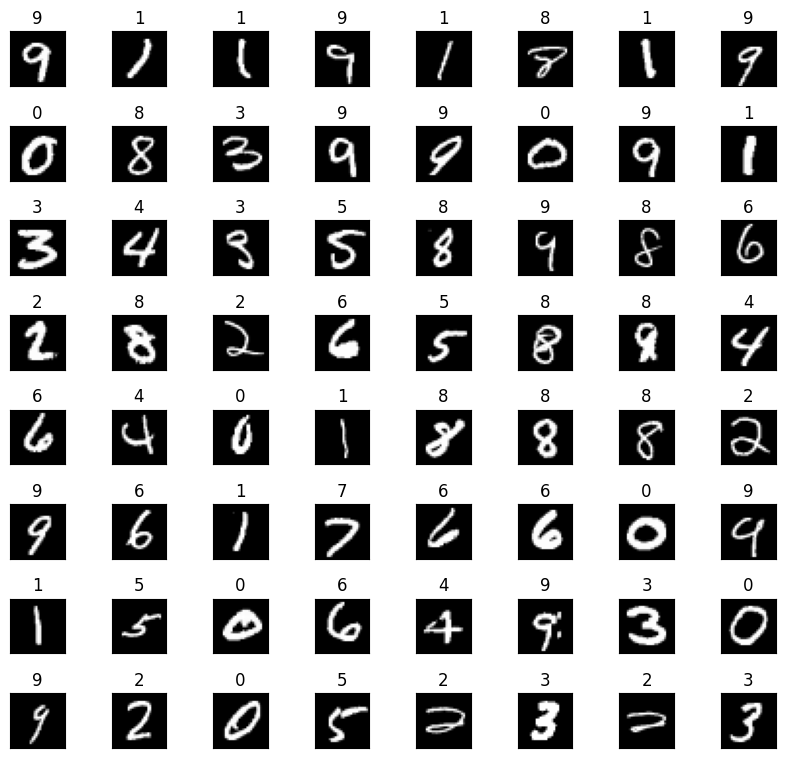

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))
plot_samples(batch_data,batch_label)

In [ ]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model_2().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
            Conv2d-2           [-1, 16, 24, 24]           1,168
            Conv2d-3           [-1, 32, 22, 22]           4,640
            Conv2d-4           [-1, 16, 22, 22]             528
            Conv2d-5             [-1, 16, 9, 9]           2,320
            Conv2d-6             [-1, 16, 7, 7]           2,320
            Conv2d-7             [-1, 10, 7, 7]             170
         AvgPool2d-8             [-1, 10, 1, 1]               0
Total params: 11,226
Trainable params: 11,226
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.31
Params size (MB): 0.04
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


CODE BLOCK: 8

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [ ]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            # loss_fn = nn.CrossEntropyLoss(reduction='sum')
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
# criterion = nn.CrossEntropyLoss()
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  # scheduler.step()

Epoch 1


Train: Loss=2.2927 Batch_id=117 Accuracy=10.08: 100%|██████████| 118/118 [00:17<00:00,  6.73it/s]


Test set: Average loss: 2.3016, Accuracy: 6742/60000 (11.24%)

Epoch 2


Train: Loss=2.2869 Batch_id=117 Accuracy=11.24: 100%|██████████| 118/118 [00:15<00:00,  7.66it/s]


Test set: Average loss: 2.2997, Accuracy: 6742/60000 (11.24%)

Epoch 3


Train: Loss=2.3032 Batch_id=117 Accuracy=11.24: 100%|██████████| 118/118 [00:15<00:00,  7.66it/s]


Test set: Average loss: 2.2949, Accuracy: 6828/60000 (11.38%)

Epoch 4


Train: Loss=2.2215 Batch_id=117 Accuracy=12.35: 100%|██████████| 118/118 [00:15<00:00,  7.72it/s]


Test set: Average loss: 2.2476, Accuracy: 8888/60000 (14.81%)

Epoch 5


Train: Loss=1.3382 Batch_id=117 Accuracy=27.17: 100%|██████████| 118/118 [00:15<00:00,  7.66it/s]


Test set: Average loss: 1.4450, Accuracy: 30029/60000 (50.05%)

Epoch 6


Train: Loss=1.0146 Batch_id=117 Accuracy=70.41: 100%|██████████| 118/118 [00:15<00:00,  7.64it/s]


Test set: Average loss: 0.8304, Accuracy: 44793/60000 (74.66%)

Epoch 7


Train: Loss=0.7557 Batch_id=117 Accuracy=82.10: 100%|██████████| 118/118 [00:15<00:00,  7.77it/s]


Test set: Average loss: 0.4983, Accuracy: 50319/60000 (83.86%)

Epoch 8


Train: Loss=0.3540 Batch_id=117 Accuracy=89.41: 100%|██████████| 118/118 [00:15<00:00,  7.61it/s]


Test set: Average loss: 0.2932, Accuracy: 54456/60000 (90.76%)

Epoch 9


Train: Loss=0.2364 Batch_id=117 Accuracy=91.97: 100%|██████████| 118/118 [00:18<00:00,  6.33it/s]


Test set: Average loss: 0.3674, Accuracy: 53173/60000 (88.62%)

Epoch 10


Train: Loss=0.1649 Batch_id=117 Accuracy=92.72: 100%|██████████| 118/118 [00:15<00:00,  7.65it/s]


Test set: Average loss: 0.2096, Accuracy: 56200/60000 (93.67%)

Epoch 11


Train: Loss=0.1391 Batch_id=117 Accuracy=93.72: 100%|██████████| 118/118 [00:15<00:00,  7.67it/s]


Test set: Average loss: 0.2266, Accuracy: 55755/60000 (92.92%)

Epoch 12


Train: Loss=0.1846 Batch_id=117 Accuracy=94.14: 100%|██████████| 118/118 [00:15<00:00,  7.61it/s]


Test set: Average loss: 0.1801, Accuracy: 56757/60000 (94.59%)

Epoch 13


Train: Loss=0.1520 Batch_id=117 Accuracy=94.74: 100%|██████████| 118/118 [00:15<00:00,  7.67it/s]


Test set: Average loss: 0.1490, Accuracy: 57257/60000 (95.43%)

Epoch 14


Train: Loss=0.1327 Batch_id=117 Accuracy=95.11: 100%|██████████| 118/118 [00:15<00:00,  7.64it/s]


Test set: Average loss: 0.1848, Accuracy: 56599/60000 (94.33%)

Epoch 15


Train: Loss=0.2066 Batch_id=117 Accuracy=95.31: 100%|██████████| 118/118 [00:15<00:00,  7.83it/s]


Test set: Average loss: 0.1310, Accuracy: 57623/60000 (96.04%)



CODE BLOCK: 11

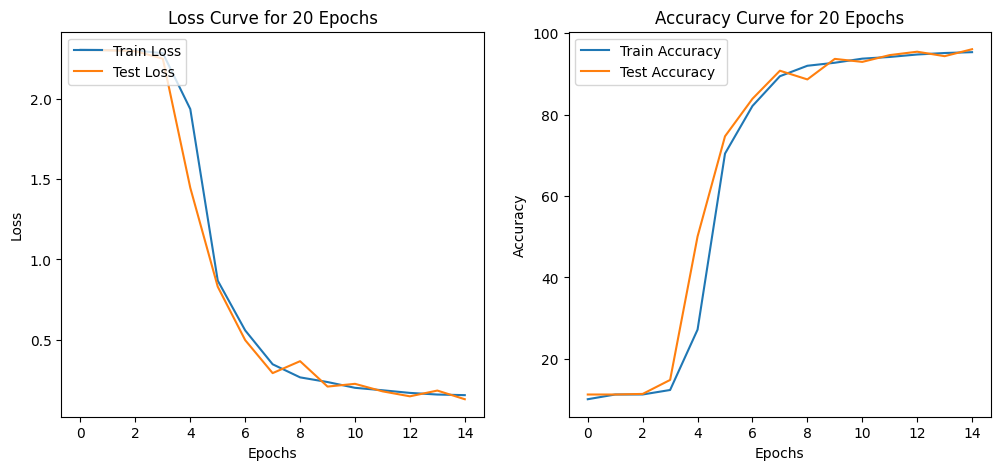

In [ ]:
plot_accuracy_metrics(train_losses,train_acc,test_losses,test_acc)